# DataLoaderの実装

In [1]:
# dataset関数の実装

import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class Dataset(Dataset):
    def __init__(self, text_paths, mel_paths, img_paths):
        self.text_paths = text_paths
        self.mel_paths = mel_paths
        self.img_paths = img_paths
        
    def __getitem__(self, index):
        return np.load(self.text_paths[index]), np.load(self.mel_paths[index]), np.load(self.img_paths[index])

    def __len__(self):
        return len(self.text_paths)

In [2]:
# collate_fn関数の実装

def pad_1d(x, max_len, constant_values=0):
    """
    1次元のテンソルをパディングする関数

    PARAMS
    -------
    x: パディングするテンソル
    max_len: パディングする長さ
    constant_values: パディングの値

    RETURNS
    -------
    x: パディング済みのテンソル
    """
    x = np.pad(
        x,
        (0, max_len - len(x)),
        mode = "constant",
        constant_values=constant_values,
    )
    return x

def pad_2d(x, max_len, constant_values=0):
    """
    2次元のテンソルをパディングする関数

    PARAMS
    -------
    x: パディングするテンソル
    max_len: パディングする長さ
    constant_values: パディングの値

    RETURNS
    -------
    x: パディング済みのテンソル
    """
    x = np.pad(
        x,
        [(0, max_len - len(x)), (0, 0)],
        mode="constant",
        constant_values=constant_values,
    )
    return x

def collate_fn(batch):
    """
    PARAMS
    -------
    batch: タプルのリスト(text, mel)

    RETURNS
    -------

    MEMO
    -------
    torch.from.numpyでnumpyのArrayからtorchのTensorに変換

    """
    xs = [x[0] for x in batch]  # text list
    ys = [x[1] for x in batch]  # mel list
    zs = [x[2] for x in batch]  # img list
    text_lens = [len(x) for x in xs]  # text_len list
    mel_lens = [len(y) for y in ys]  # mel_len list
    img_lens = [len(z) for z in zs]  # img_len list
    text_max_len = max(text_lens)
    mel_max_len = max(mel_lens)
    x_batch = torch.stack([torch.from_numpy(pad_1d(x, text_max_len)) for x in xs])
    y_batch = torch.stack([torch.from_numpy(pad_2d(y, mel_max_len)) for y in ys])
    z_batch = torch.stack([torch.from_numpy(pad_2d(z, mel_max_len)) for z in zs])
    text_lens = torch.tensor(text_lens, dtype=torch.long)
    mel_lens = torch.tensor(mel_lens, dtype=torch.long)
    
    return x_batch, y_batch, z_batch, text_lens, mel_lens

In [3]:
import glob
import torch
from torch.utils.data import DataLoader

TEXT_DIR = "F:/ROHAN4600マルチモーダルデータベース/text_data/*"
MEL_DIR = "F:/ROHAN4600マルチモーダルデータベース/normalized_db_data/*"
IMG_DIR = "F:/ROHAN4600マルチモーダルデータベース/img_data2/*"

textlist = sorted(glob.glob(TEXT_DIR))
mellist = sorted(glob.glob(MEL_DIR))
imglist = sorted(glob.glob(IMG_DIR))
#print(mellist)

dataset = Dataset(textlist, mellist, imglist)
#batch_size = 32
#data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [4]:
n_samples = len(dataset)
train_size = int(len(dataset) * 0.9)
test_size = n_samples - train_size
#print(train_size)
#print(test_size)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#print(len(train_dataset))
#print(len(test_dataset))

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(test_dataset))
print(len(train_loader))
print(len(test_loader))

4140
460
259
29


In [6]:
text, mel, img, text_len, mel_len = next(iter(train_loader))
print(tuple(text.shape))
print(tuple(mel.shape))
print(tuple(img.shape))
print(text_len)
print(mel_len)
print(text.dtype)
print(mel.dtype)
print(img.dtype)
print(text_len.dtype)
print(mel_len.dtype)

(16, 92)
(16, 1125, 80)
(16, 1125, 512)
tensor([73, 42, 58, 46, 77, 57, 55, 92, 80, 69, 59, 80, 67, 64, 66, 75])
tensor([ 569,  497,  535,  497,  553,  577,  473, 1125,  663,  545,  575,  941,
         615,  537,  607,  591])
torch.int32
torch.float32
torch.float32
torch.int64
torch.int64


# 学習ループの実装

In [7]:
# 学習モデル
from img_Tacotron2 import Tacotron2

net = Tacotron2()
net.cuda()  # GPU対応
print(net)

Tacotron2(
  (encoder): Encoder(
    (embed): Embedding(32, 512, padding_idx=0)
    (convolutions): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
    (blstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )


In [7]:
from img_Tacotron2 import Tacotron2

MODEL_DIR = "F:/model/D4/model300_100_n"
net = Tacotron2()
net.load_state_dict(torch.load(MODEL_DIR))
net.cuda()  # GPU対応
print(net)

Tacotron2(
  (encoder): Encoder(
    (embed): Embedding(32, 512, padding_idx=0)
    (convolutions): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
    (blstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )


In [8]:
def get_mask_from_lengths(lengths):
    """
    MEMO
    -------
    torch.maxは与えられたテンソルの最大値を返す関数
    .item()でテンソルの要素をpython組み込み型として取得
    torch.arangeは第一引数から第二引数まで第三引数間隔のテンソルが生成される
    """
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, device=lengths.device, dtype=lengths.dtype)
    mask = (ids < lengths.unsqueeze(1)).byte()
    mask = torch.le(mask, 0)
    return mask

In [9]:
mask = ~get_mask_from_lengths(mel_len)
print(mask.shape)

torch.Size([16, 719])


In [10]:
from torch import optim
import torch.nn as nn

# 平均二乗誤差
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters(), lr=0.0001)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=100000)

# 損失のログ
record_loss_train = []
record_loss_test = []

# エポック数
epoch = 10

for i in range(epoch):
    net.train()
    loss_train = 0
    for j, (text, mel, img, text_len, mel_len) in enumerate(train_loader):
        
        text_len, indices = torch.sort(text_len, dim=0, descending=True)
        text, mel, img, mel_len = text[indices], mel[indices], img[indices], mel_len[indices]  
        text, mel, img = text.cuda(), mel.float().cuda(), img.cuda()
        
        # 順伝播
        outs, outs_fine, att_ws = net(text, text_len, img, mel.transpose(1, 2))
        
        # ゼロパディングを除くためにマスクを適用
        mask = ~get_mask_from_lengths(mel_len).unsqueeze(-1).to(mel.device)
        mel = mel.masked_select(mask)
        outs = outs.masked_select(mask)
        outs_fine = outs_fine.masked_select(mask)
        
        # 損失の計算
        decoder_out_loss = loss_fnc(outs, mel)
        postnet_out_loss = loss_fnc(outs_fine, mel)
        
        # 損失の合計
        loss = decoder_out_loss + postnet_out_loss
        
        loss_train += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
    loss_train /= j+1
    record_loss_train.append(loss_train)
    
    net.eval()
    loss_test = 0
    for j, (text, mel, img, text_len, mel_len) in enumerate(test_loader):
        text_len, indices = torch.sort(text_len, dim=0, descending=True)
        text, mel, img, mel_len = text[indices], mel[indices], img[indices], mel_len[indices]  
        text, mel, img = text.cuda(), mel.float().cuda(), img.cuda()
        
        # 順伝播
        outs, outs_fine, att_ws = net(text, text_len, img, mel.transpose(1, 2))
        
        # ゼロパディングを除くためにマスクを適用
        mask = ~get_mask_from_lengths(mel_len).unsqueeze(-1).to(mel.device)
        mel = mel.masked_select(mask)
        outs = outs.masked_select(mask)
        outs_fine = outs_fine.masked_select(mask)
        
        # 損失の計算
        decoder_out_loss = loss_fnc(outs, mel)
        postnet_out_loss = loss_fnc(outs_fine, mel)
        
        # 損失の合計
        loss = decoder_out_loss + postnet_out_loss
        
        loss_test += loss.item()
        
    loss_test /= j+1
    record_loss_test.append(loss_test)
    
    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)


Epoch: 0 Loss_Train: 0.0034332783141220167 Loss_Test: 0.002845337839219077
Epoch: 1 Loss_Train: 0.0034022282640014606 Loss_Test: 0.0028352501304370575
Epoch: 2 Loss_Train: 0.003391903854769917 Loss_Test: 0.0028409996423228033
Epoch: 3 Loss_Train: 0.0033798157965627762 Loss_Test: 0.002843296083075733
Epoch: 4 Loss_Train: 0.0033738273267839174 Loss_Test: 0.0028428441106245436
Epoch: 5 Loss_Train: 0.003366948520714367 Loss_Test: 0.002847144958274118
Epoch: 6 Loss_Train: 0.003361204789203509 Loss_Test: 0.002839262549091002
Epoch: 7 Loss_Train: 0.003355427148021959 Loss_Test: 0.002845324383213602
Epoch: 8 Loss_Train: 0.0033531806972884647 Loss_Test: 0.002851072152883842
Epoch: 9 Loss_Train: 0.003347528654305286 Loss_Test: 0.0028451510207277947


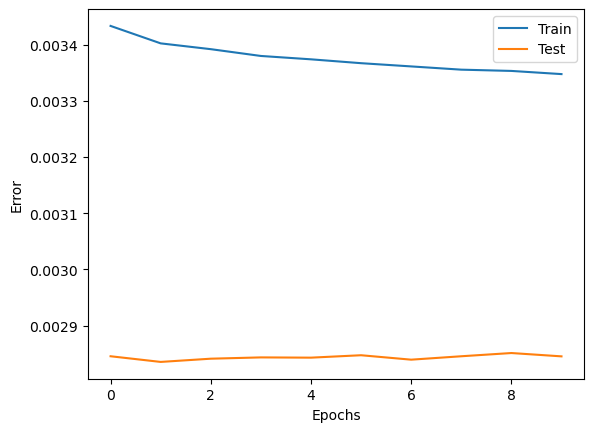

In [11]:
# 誤差の推移
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [12]:
MODEL_DIR = "F:/model/D4/model300_110_n"
torch.save(net.state_dict(), MODEL_DIR)

In [15]:
print(record_loss_train.dtype)

AttributeError: 'list' object has no attribute 'dtype'

In [14]:
LOSS_TRAIN_DIR = "F:/model/D4/model300_loss_train.npy"
LOSS_TEST_DIR = "F:/model/D4/model300_loss_test.npy"

loss_train = np.array(record_loss_train)
loss_test = np.array(record_loss_test)

np.save(LOSS_TRAIN_DIR, loss_train)
np.save(LOSS_TEST_DIR, loss_test)

# モデルの読み込み、推論

In [7]:
from img_Tacotron2 import Tacotron2

MODEL_DIR = "F:/model/D4/model300_43_n"
net2 = Tacotron2()
net2.load_state_dict(torch.load(MODEL_DIR))

<All keys matched successfully>

In [8]:
net2.cuda()

Tacotron2(
  (encoder): Encoder(
    (embed): Embedding(32, 512, padding_idx=0)
    (convolutions): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): ConvNorm(
        (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      )
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
    (blstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )


In [9]:
from torch.utils.data import DataLoader

data_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)
text, mel, img, text_len, mel_len = next(iter(data_loader))

#plt.imshow(image[0].permute(1, 2, 0))
#print(image)

net2.eval()
text, img = text.cuda(), img.cuda()

In [10]:
from torch.utils.data import DataLoader

data_loader2 = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)
text2, mel2, img2, text_len2, mel_len2 = next(iter(data_loader))

#plt.imshow(image[0].permute(1, 2, 0))
#print(image)

text2, img2 = text2.cuda(), img2.cuda()

In [11]:
print(tuple(text.shape))
print(tuple(mel.shape))
print(tuple(img.shape))
print(text_len)
print(mel_len)
print(text.dtype)
print(mel.dtype)
print(img.dtype)
print(text_len.dtype)
print(mel_len.dtype)

(1, 73)
(1, 617, 80)
(1, 617, 512)
tensor([73])
tensor([617])
torch.int32
torch.float32
torch.float32
torch.int64
torch.int64


In [12]:
print(tuple(text2.shape))
print(tuple(mel2.shape))
print(tuple(img2.shape))
print(text_len2)
print(mel_len2)
print(text2.dtype)
print(mel2.dtype)
print(img2.dtype)
print(text_len2.dtype)
print(mel_len2.dtype)

(1, 46)
(1, 369, 80)
(1, 369, 512)
tensor([46])
tensor([369])
torch.int32
torch.float32
torch.float32
torch.int64
torch.int64


In [13]:
outs, outs_fine, att_ws = net2.inference(text, text_len, img)

In [14]:
outs2, outs_fine2, att_ws2 = net2.inference(text2, text_len2, img2)

In [15]:
outs3, outs_fine3, att_ws3 = net2.inference(text2, text_len2, img)

In [16]:
import matplotlib.pyplot as plt

def plot_attention(alignment):
    """Plot attention.
    Args:
        alignment (np.ndarray): Attention.
    """
    fig, ax = plt.subplots()
    alignment = alignment.cpu().data.numpy().T
    im = ax.imshow(alignment, aspect="auto", origin="lower", interpolation="none")
    fig.colorbar(im, ax=ax)
    plt.xlabel("Decoder time step")
    plt.ylabel("Encoder time step")
    #return fig

torch.Size([1, 689, 67])


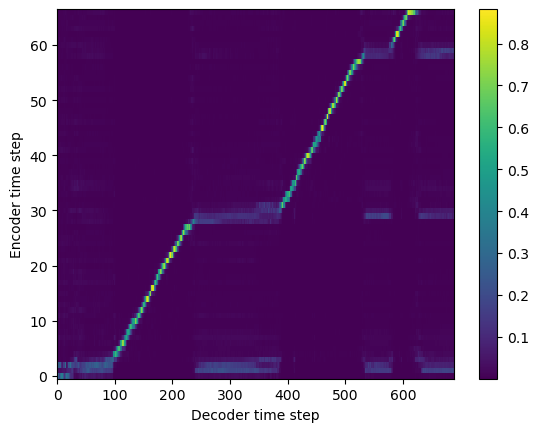

In [17]:
print(att_ws.shape)
plot_attention(att_ws)

torch.Size([1, 369, 46])


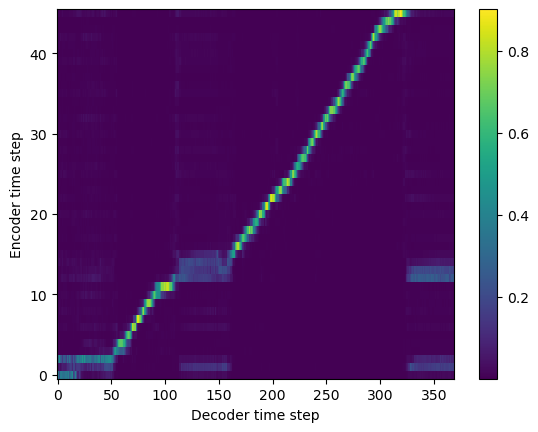

In [18]:
print(att_ws2.shape)
plot_attention(att_ws2)

torch.Size([1, 689, 46])


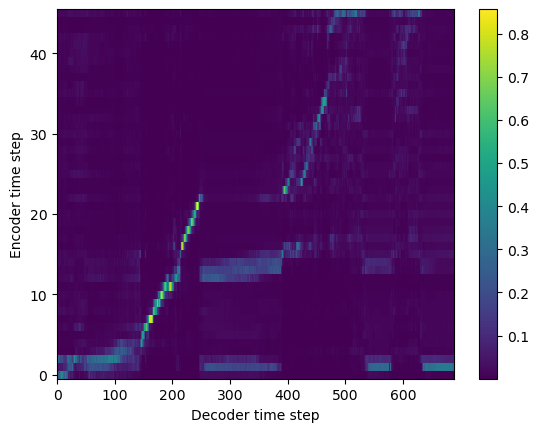

In [19]:
print(att_ws3.shape)
plot_attention(att_ws3)

In [20]:
outs2 = outs2.to('cpu').detach().numpy()
print(outs2.shape)
outs_fine2 = outs_fine2.to('cpu').detach().numpy()
print(outs_fine2.shape)
#text3 = text3.to('cpu').detach().numpy()
#print(text.shape)

(1, 369, 80)
(1, 369, 80)


In [21]:
outs3 = outs3.to('cpu').detach().numpy()
print(outs.shape)
outs_fine3 = outs_fine3.to('cpu').detach().numpy()
print(outs_fine.shape)
#text3 = text3.to('cpu').detach().numpy()
#print(text.shape)

torch.Size([1, 689, 80])
torch.Size([1, 689, 80])


In [68]:
OUTPUT_PATH = "F:/ROHAN4600マルチモーダルデータベース/mel_outs_n/"
outsdir = OUTPUT_PATH + "outs_4.npy"
outsfinedir = OUTPUT_PATH + "outs_fine_4.npy"
meldir = OUTPUT_PATH + "mel_4.npy"
#textdir = OUTPUT_PATH + "text_5.npy"
np.save(outsdir, outs2)
np.save(outsfinedir, outs_fine2)
np.save(meldir, mel2)
#np.save(textdir, text)

In [22]:
OUTPUT_PATH = "F:/ROHAN4600マルチモーダルデータベース/mel_outs_n/"
outsdir = OUTPUT_PATH + "outs_4.npy"
outsfinedir = OUTPUT_PATH + "outs_fine_4.npy"
meldir = OUTPUT_PATH + "mel_4.npy"
#textdir = OUTPUT_PATH + "text_5.npy"
np.save(outsdir, outs3)
np.save(outsfinedir, outs_fine3)
np.save(meldir, mel2)
#np.save(textdir, text)